## Complete MLP Training

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("names.txt", "r").read().split("\n")
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# building vocabulary
chars = sorted(list(set("".join(words))))
stoi = {char: i+1 for i, char in enumerate(chars)}
stoi["."] = 0
itos = {i: char for char, i in stoi.items()}

In [5]:
vocab_size = len(stoi)

In [6]:
# dataset
block_size = 3 # our context window 

def build_dataset(words: list):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
# create train, test and validation dataset split
import random
random.seed(2)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182481, 3]) torch.Size([182481])
torch.Size([22849, 3]) torch.Size([22849])
torch.Size([22816, 3]) torch.Size([22816])


In [8]:
# MLP model

n_embed = 10 # embedding dimension
n_hidden = 200 # number of hidden neuron

C = torch.randn((vocab_size, n_embed)) # embedding matrix for all vocab with embedding dim hidden size
W1 = torch.randn((n_embed*block_size, n_hidden)) # weight matrix of input layer to hidden layer
# input_dim: n_embed*block_size i.e 10*3 = 30
b1 = torch.randn((n_hidden,)) # bias of hidden layer 1
W2 = torch.randn((n_hidden, vocab_size)) # weight matrix of hidden layer to output layer
b2 = torch.randn((vocab_size,)) # bias of output layer

parameters = [C, W1, b1, W2, b2]

print(sum(p.numel() for p in parameters))


11897


In [9]:
for p in parameters:
    p.requires_grad = True

In [10]:
torch.randint(0,10, (2,))

tensor([9, 6])

In [11]:
# optimization

max_step = 30000
batch_size = 32
lossi = []

for i in range(max_step):
    # minibatch
    ix = torch.randint(0, len(Ytr), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward propagation
    emb = C[Xb] # embedding
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # backward propagation
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # gradient descent
    lr = 0.01 if i > 15000 else 0.1
    for p in parameters:
        p.data += p.grad * -lr
    
    # track error
    if i % 1000 == 0:
        print(f"{i}/{max_step} and Error: {loss.item()}")
    lossi.append(loss.log10().item())

0/30000 and Error: 23.799198150634766
1000/30000 and Error: 4.048347473144531
2000/30000 and Error: 3.2066242694854736
3000/30000 and Error: 3.354234218597412
4000/30000 and Error: 3.468254804611206
5000/30000 and Error: 2.731295108795166
6000/30000 and Error: 2.6358001232147217
7000/30000 and Error: 2.4683034420013428
8000/30000 and Error: 2.512857675552368
9000/30000 and Error: 2.194101095199585
10000/30000 and Error: 2.302581787109375
11000/30000 and Error: 2.969092845916748
12000/30000 and Error: 2.509819746017456
13000/30000 and Error: 2.858711004257202
14000/30000 and Error: 2.5485758781433105
15000/30000 and Error: 1.9805362224578857
16000/30000 and Error: 2.586013078689575
17000/30000 and Error: 2.32790470123291
18000/30000 and Error: 2.330793857574463
19000/30000 and Error: 2.2033889293670654
20000/30000 and Error: 2.642727851867676
21000/30000 and Error: 2.2507805824279785
22000/30000 and Error: 2.6600866317749023
23000/30000 and Error: 2.5354223251342773
24000/30000 and Erro

Here we get the loss value at the start `26.99` error. At initialization and rapidly comes to `2`. We can expect to see a loss that we calculate.

In [12]:
probability_of_one_word = torch.tensor(1/27)
log_probability_of_one_word = probability_of_one_word.log()
loss_expected_value = -log_probability_of_one_word
loss_expected_value # we expect to see 3.29

tensor(3.2958)

In [13]:
probs = torch.tensor([0.0, 0.0, 0.0, 0.0]) # for 4 words logits of nn with low prediction probability
probs = F.softmax(probs, dim=0) # get the prob
loss = -probs[2].log() # if the label is 2
probs, loss # we record 1.383 for 0.0 probability

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [14]:
probs = torch.tensor([0.0, 5.0, 0.0, 0.0]) # for 4 words logits of nn with low prediction probability
probs = F.softmax(probs, dim=0) # get the prob
loss = -probs[1].log() # if the label is 1 then we get 0.02 error
loss2 = -probs[0].log() # if the label is 0 then we get 5.0 error
probs, loss, loss2 # because if the prob is 0the index but have low prob on output then we get high error

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(0.0200), tensor(5.0200))

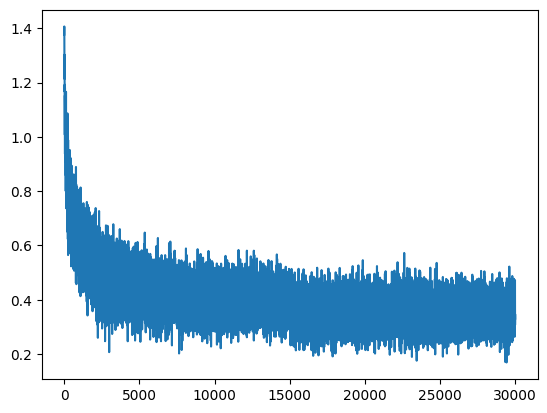

In [15]:
plt.plot(lossi)

In [16]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "validation": (Xva, Yva),
        "test": (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss("train")
split_loss("validation")

train 2.26721453666687
validation 2.3110876083374023


In [17]:
torch.tensor([[1,2,3]])

tensor([[1, 2, 3]])

In [18]:
C[torch.tensor([[1,2,3]])].shape

torch.Size([1, 3, 10])

In [19]:
C[[[[0,0,0]]]].shape

torch.Size([1, 3, 10])

In [20]:
# sample from the model
for _ in range(15):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (1, n_hidden)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, 1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # terminate if stop token predicted
        if ix == 0:
            break
        
    print("".join([itos[ix] for ix in out]))

rery.
akamtharmineea.
ruka.
isejilancaja.
jolo.
abdaka.
adi.
las.
samri.
emaise.
anyalee.
elwa.
tecne.
xyce.
dilikeshionalilon.


Why high error at step 1 then suddenly drop to 0 : due to wrong initialization

In [21]:
# MLP model

n_embed = 10 # embedding dimension
n_hidden = 200 # number of hidden neuron

C = torch.randn((vocab_size, n_embed)) # embedding matrix for all vocab with embedding dim hidden size
W1 = torch.randn((n_embed*block_size, n_hidden)) # weight matrix of input layer to hidden layer
# input_dim: n_embed*block_size i.e 10*3 = 30
b1 = torch.randn((n_hidden,)) # bias of hidden layer 1
W2 = torch.randn((n_hidden, vocab_size)) * 0.1 # scale down the weight matrix
b2 = torch.randn((vocab_size,)) * 0 # 0 at initialization

parameters = [C, W1, b1, W2, b2]

print(sum(p.numel() for p in parameters))


11897


In [22]:
for p in parameters:
    p.requires_grad = True

In [23]:

# optimization

max_step = 30000
batch_size = 32
lossi = []

for i in range(max_step):
    # minibatch
    ix = torch.randint(0, len(Ytr), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward propagation
    emb = C[Xb] # embedding
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # backward propagation
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # gradient descent
    lr = 0.01 if i > 15000 else 0.1
    for p in parameters:
        p.data += p.grad * -lr
    
    # track error
    if i % 1000 == 0:
        print(f"{i}/{max_step} and Error: {loss.item()}")
    lossi.append(loss.log10().item())

0/30000 and Error: 3.7655014991760254
1000/30000 and Error: 2.5725743770599365
2000/30000 and Error: 2.4531776905059814
3000/30000 and Error: 2.2848236560821533
4000/30000 and Error: 2.4950947761535645
5000/30000 and Error: 2.400466203689575
6000/30000 and Error: 2.323908567428589
7000/30000 and Error: 2.584913969039917
8000/30000 and Error: 1.993933916091919
9000/30000 and Error: 2.3325695991516113
10000/30000 and Error: 2.5771191120147705
11000/30000 and Error: 2.5760953426361084
12000/30000 and Error: 2.445796012878418
13000/30000 and Error: 2.120861291885376
14000/30000 and Error: 2.2511537075042725
15000/30000 and Error: 2.3004024028778076
16000/30000 and Error: 2.567549705505371
17000/30000 and Error: 1.708171010017395
18000/30000 and Error: 1.7054909467697144
19000/30000 and Error: 1.9544568061828613
20000/30000 and Error: 2.351945400238037
21000/30000 and Error: 2.206735134124756
22000/30000 and Error: 2.2062034606933594
23000/30000 and Error: 2.216548442840576
24000/30000 and 

Here after initializing the weight and bias a bit differently we got starting error `3.62` which is like what we have expected

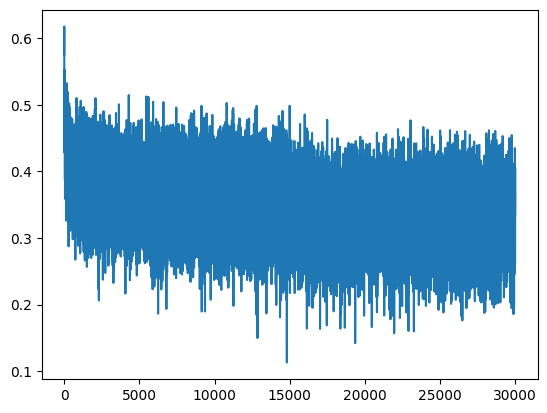

In [24]:
plt.plot(lossi)

Now plot of the error donot have hat hockey

(array([  16.,   77.,  307.,  883., 1518., 1436.,  845.,  249.,   59.,
          10.]),
 array([-0.49760884, -0.3958312 , -0.29405352, -0.19227588, -0.09049822,
         0.01127943,  0.11305709,  0.21483475,  0.31661239,  0.41839007,
         0.52016771]),
 <BarContainer object of 10 artists>)

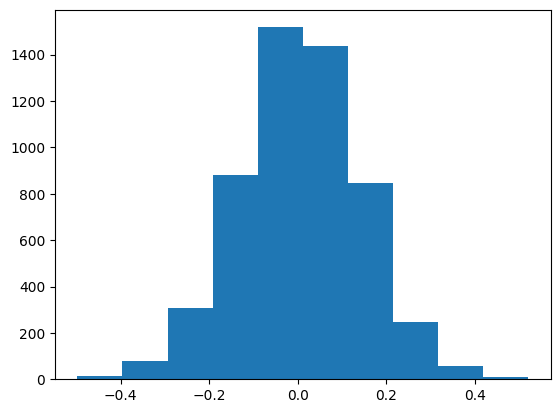

In [25]:
plt.hist(W2.flatten().detach().numpy(), bins=10)

(array([2339.,  176.,   69.,   71.,   44.,   58.,   48.,   30.,   23.,
          56.,   25.,   31.,   10.,   15.,   21.,   12.,   12.,   33.,
          23.,   28.,   10.,   20.,   23.,   21.,   17.,   14.,   15.,
          25.,   18.,   18.,    9.,   23.,   38.,   13.,    9.,   19.,
          26.,   32.,   28.,   32.,   22.,   29.,   39.,   33.,   57.,
          53.,   82.,  106.,  137., 2308.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

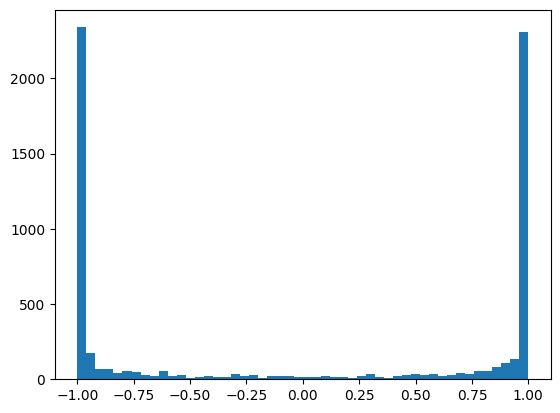

In [26]:
plt.hist(h.view(-1).tolist(), 50)

Here in the hidden activation due to `tanh` we have most of the values at `-1.0` and `1.0`. because of the preactivation value close to `0 and 1` we will get such output from hidden layer and due to which gradient will be destroyed here.

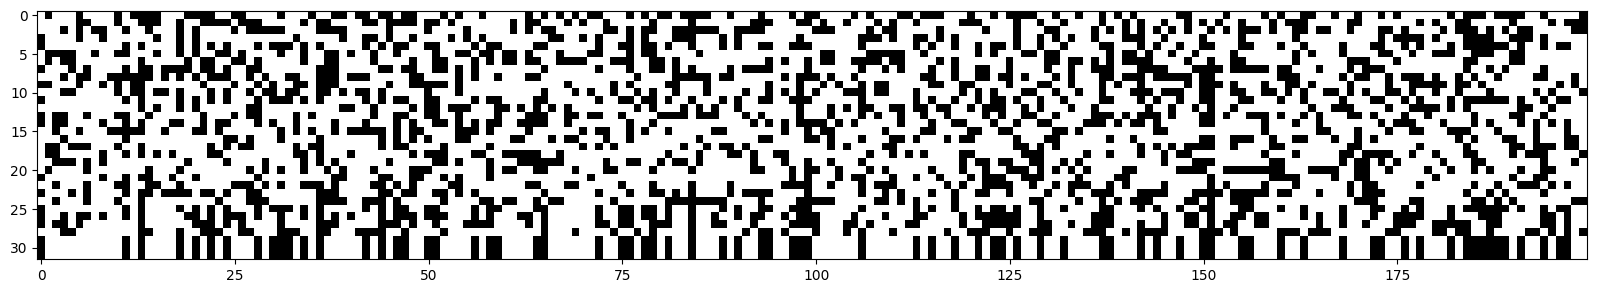

In [27]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

white pixel shows that the values are in the flat region of tanh i.e near to -1 and -1. so from here we can say all these tanh neurons are active and we will be in trouble if entire column are white which is `dead neuron` that is no single example ever activate that neuron and if neuron is at tail it will not learn anything.

Not learn means **tanh** fires -1 and 1 completely and due to which neuron will not learn anything because gradient will not flow.

This is not the case for only **tanh** but for other `non linear activation` also.

`**ReLU*` has a completely flat region below `x below 0` and `a dead ReLU` neuron may occur when it never turns on because the input it get is less than 0.

Sometimes during `optimization` due to `high learning rate` neuron might get `high gradient` and gets `knocked out` and will fall into the region where `zero learning` happen. as in the `ReLU and tanh` case mentioned above.

so these are the things we need to take care of 
- be careful of **preactivations**
- watch out **gradients**

(array([  1.,   1.,   0.,   0.,   0.,   1.,   1.,   2.,   3.,   2.,  10.,
         11.,  10.,  20.,  35.,  36.,  82.,  69.,  86., 114., 150., 231.,
        260., 277., 300., 362., 367., 397., 413., 414., 414., 355., 355.,
        308., 250., 255., 176., 161., 122., 101.,  70.,  36.,  48.,  32.,
         25.,  17.,   8.,   7.,   1.,   4.]),
 array([-26.51917648, -25.60236088, -24.68554527, -23.76872967,
        -22.85191406, -21.93509846, -21.01828285, -20.10146725,
        -19.18465164, -18.26783604, -17.35102043, -16.43420483,
        -15.51738922, -14.60057362, -13.68375801, -12.76694241,
        -11.8501268 , -10.9333112 , -10.01649559,  -9.09967999,
         -8.18286438,  -7.26604877,  -6.34923317,  -5.43241756,
         -4.51560196,  -3.59878635,  -2.68197075,  -1.76515514,
         -0.84833954,   0.06847607,   0.98529167,   1.90210728,
          2.81892288,   3.73573849,   4.65255409,   5.5693697 ,
          6.4861853 ,   7.40300091,   8.31981651,   9.23663212,
         10.153447

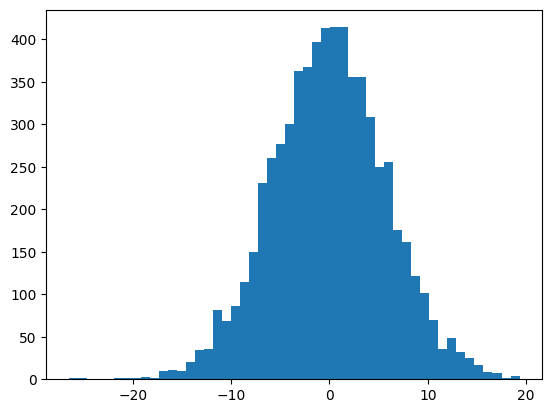

In [28]:
plt.hist(hpreact.view(-1).tolist(), 50)

Preactivation has `normal distribution`

Weight Initialization

In [29]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

11897


In [30]:
# optimization

max_step = 30000
batch_size = 32
lossi = []

for i in range(max_step):
    # minibatch
    ix = torch.randint(0, len(Ytr), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward propagation
    emb = C[Xb] # embedding
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # backward propagation
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # gradient descent
    lr = 0.01 if i > 1500 else 0.1
    for p in parameters:
        p.data += p.grad * -lr
    
    # track error
    if i % 1000 == 0:
        print(f"{i}/{max_step} and Error: {loss.item()}")
    lossi.append(loss.log10().item())
    break

0/30000 and Error: 3.2988858222961426


(array([  1.,   1.,   1.,   2.,   5.,   3.,   6.,   9.,  14.,  10.,  29.,
         47.,  62.,  59.,  86., 113., 146., 201., 216., 269., 302., 303.,
        367., 422., 416., 398., 414., 371., 369., 308., 285., 255., 184.,
        170., 136., 118.,  92.,  78.,  40.,  30.,  24.,  12.,   4.,   9.,
          6.,   2.,   2.,   1.,   1.,   1.]),
 array([-2.12463284, -2.03955162, -1.9544704 , -1.86938918, -1.78430796,
        -1.69922674, -1.61414552, -1.5290643 , -1.44398308, -1.35890186,
        -1.27382064, -1.18873942, -1.1036582 , -1.01857698, -0.93349576,
        -0.84841454, -0.76333332, -0.6782521 , -0.59317088, -0.50808966,
        -0.42300844, -0.33792722, -0.252846  , -0.16776478, -0.08268356,
         0.00239766,  0.08747888,  0.1725601 ,  0.25764132,  0.34272254,
         0.42780375,  0.51288497,  0.59796619,  0.68304741,  0.76812863,
         0.85320985,  0.93829107,  1.02337229,  1.10845351,  1.19353473,
         1.27861595,  1.36369717,  1.44877839,  1.53385961,  1.61894083,
 

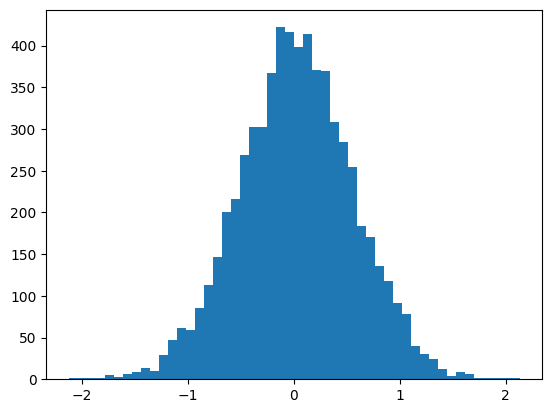

In [31]:
plt.hist(hpreact.view(-1).tolist(), 50)

Preactivation is now between -1 and 1 so there are only few value which are at -1 and 1 so only those will not learn most of them are active

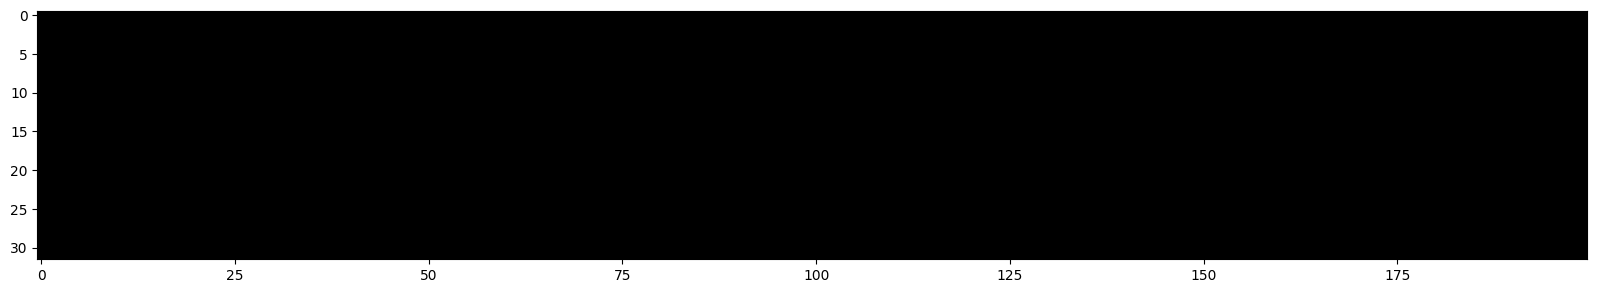

In [32]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

Here all neuron are active

(array([ 10.,  18.,  24.,  52.,  73.,  61.,  74.,  89., 111., 101., 139.,
        131., 134., 140., 162., 164., 156., 142., 166., 182., 180., 199.,
        185., 181., 199., 198., 172., 189., 188., 191., 189., 166., 183.,
        160., 174., 162., 165., 155., 157., 121., 119., 119., 125., 101.,
        104.,  76.,  51.,  33.,  20.,   9.]),
 array([-9.71852362e-01, -9.32972969e-01, -8.94093575e-01, -8.55214182e-01,
        -8.16334789e-01, -7.77455395e-01, -7.38576002e-01, -6.99696609e-01,
        -6.60817215e-01, -6.21937822e-01, -5.83058429e-01, -5.44179035e-01,
        -5.05299642e-01, -4.66420249e-01, -4.27540855e-01, -3.88661462e-01,
        -3.49782069e-01, -3.10902675e-01, -2.72023282e-01, -2.33143889e-01,
        -1.94264495e-01, -1.55385102e-01, -1.16505709e-01, -7.76263154e-02,
        -3.87469220e-02,  1.32471323e-04,  3.90118647e-02,  7.78912580e-02,
         1.16770651e-01,  1.55650045e-01,  1.94529438e-01,  2.33408831e-01,
         2.72288225e-01,  3.11167618e-01,  3.50047

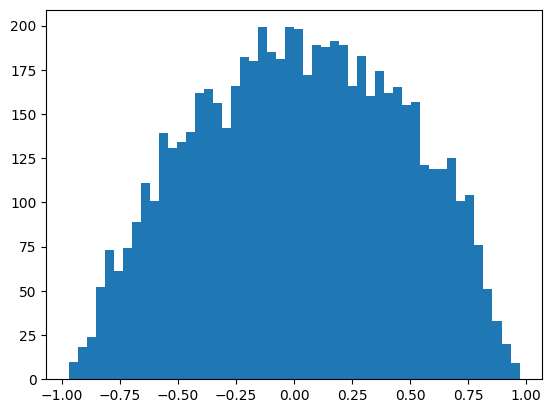

In [33]:
plt.hist(h.view(-1).tolist(), 50)

our activation are between -1 and 1 as we want

### what is the problem
Even when we dont optimize initializing weights we were getting a generalization error just as equal after fixing saturating tanh value. This is because **shallow neural network** will learn easily because they are not complex but as we train **deeper neural networks** we might not get expected result.

## How to set appropriate initial weight

tensor(0.0048) tensor(1.0048)
tensor(-0.0038) tensor(1.0102)


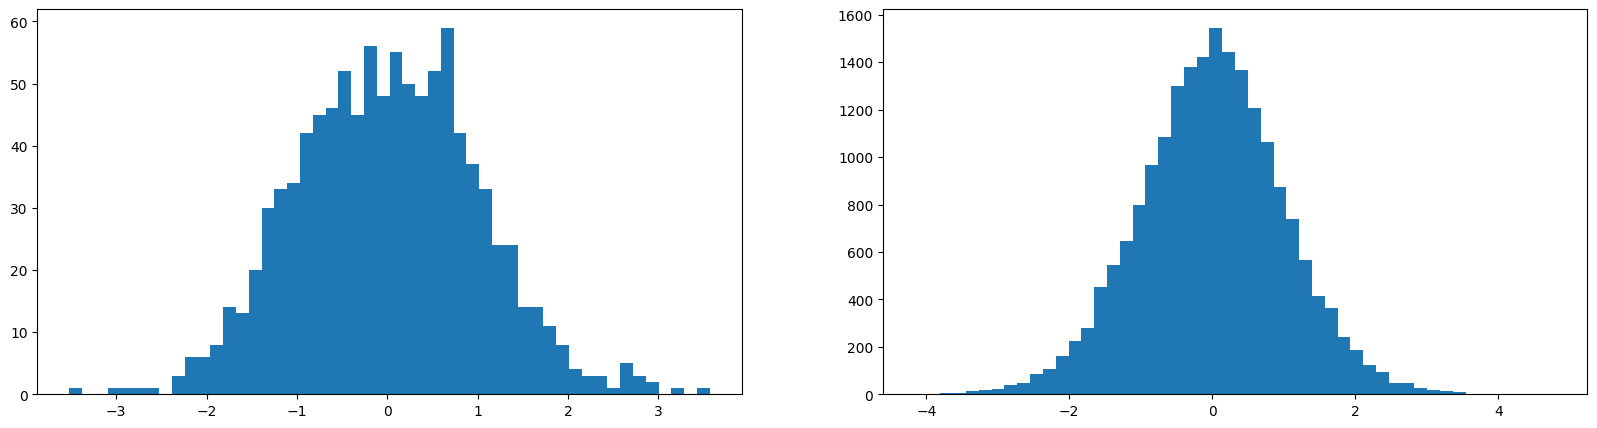

In [45]:
x = torch.randn(100, 10) # gaussian distribution
w = torch.randn(10, 200) / 10**0.5 # to make gaussian distribution
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), 50)
plt.show()

gain / sqrt of fan_in

In [46]:
(5/3) / (30**0.5)

0.3042903097250923

In [47]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

11897


In [48]:
# optimization

max_step = 30000
batch_size = 32
lossi = []

for i in range(max_step):
    # minibatch
    ix = torch.randint(0, len(Ytr), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward propagation
    emb = C[Xb] # embedding
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # backward propagation
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # gradient descent
    lr = 0.01 if i > 1500 else 0.1
    for p in parameters:
        p.data += p.grad * -lr
    
    # track error
    if i % 1000 == 0:
        print(f"{i}/{max_step} and Error: {loss.item()}")
    lossi.append(loss.log10().item())

0/30000 and Error: 3.313579797744751
1000/30000 and Error: 2.3482093811035156
2000/30000 and Error: 2.2295010089874268
3000/30000 and Error: 2.127786159515381
4000/30000 and Error: 2.639529228210449
5000/30000 and Error: 2.2155227661132812
6000/30000 and Error: 2.430901288986206
7000/30000 and Error: 2.2111260890960693
8000/30000 and Error: 2.5957300662994385
9000/30000 and Error: 2.111637592315674
10000/30000 and Error: 2.0876755714416504
11000/30000 and Error: 2.2275238037109375
12000/30000 and Error: 2.215092420578003
13000/30000 and Error: 2.2170872688293457
14000/30000 and Error: 2.3171260356903076
15000/30000 and Error: 2.219909906387329
16000/30000 and Error: 2.1075384616851807
17000/30000 and Error: 2.183863639831543
18000/30000 and Error: 2.536426544189453
19000/30000 and Error: 1.9938007593154907
20000/30000 and Error: 2.2122111320495605
21000/30000 and Error: 2.343491554260254
22000/30000 and Error: 2.0641934871673584
23000/30000 and Error: 2.427732467651367
24000/30000 and 

## Batch Normalization

In [54]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden)) # batch normalization gain
bnbias = torch.ones((1, n_hidden)) # batch normalization bias

parameters = [C, W1, W2, b1, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12297


if we want gaussian distribution then why dont we take the hidden layer output and make it gaussian then?

In [51]:
hpreact.mean(0, keepdim=True).shape # mean over all elements in a batch

torch.Size([1, 200])

In [52]:
hpreact.std(0, keepdim=True).shape # std over all elements in a batch

torch.Size([1, 200])

In [56]:
# optimization

max_step = 30000
batch_size = 32
lossi = []

for i in range(max_step):
    # minibatch
    ix = torch.randint(0, len(Ytr), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward propagation
    emb = C[Xb] # embedding
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # backward propagation
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # gradient descent
    lr = 0.01 if i > 1500 else 0.1
    for p in parameters:
        p.data += p.grad * -lr
    
    # track error
    if i % 1000 == 0:
        print(f"{i}/{max_step} and Error: {loss.item()}")
    lossi.append(loss.log10().item())

0/30000 and Error: 2.079169273376465
1000/30000 and Error: 2.325002670288086
2000/30000 and Error: 1.9885456562042236
3000/30000 and Error: 2.2175588607788086
4000/30000 and Error: 2.478675603866577
5000/30000 and Error: 2.1198956966400146
6000/30000 and Error: 2.213047742843628
7000/30000 and Error: 2.065531015396118
8000/30000 and Error: 1.6902035474777222
9000/30000 and Error: 2.4903135299682617
10000/30000 and Error: 2.122081756591797
11000/30000 and Error: 2.296205997467041
12000/30000 and Error: 2.3208892345428467
13000/30000 and Error: 2.2509610652923584
14000/30000 and Error: 2.3483712673187256
15000/30000 and Error: 2.5320866107940674
16000/30000 and Error: 2.202446460723877
17000/30000 and Error: 2.10074782371521
18000/30000 and Error: 2.550647497177124
19000/30000 and Error: 2.2800345420837402
20000/30000 and Error: 2.0667507648468018
21000/30000 and Error: 2.3246684074401855
22000/30000 and Error: 2.6084580421447754
23000/30000 and Error: 2.381523847579956
24000/30000 and E

inference time what to do

In [57]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [58]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "validation": (Xva, Yva),
        "test": (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss("train")
split_loss("validation")

train 2.2033002376556396
validation 2.2232699394226074
